# k-Nearest Neighbors (KNN)

This notebook demonstrates **k-Nearest Neighbors** for:
- **Classification** on the **Iris** dataset (scikit-learn built-in)
- **Regression** on the **Diabetes** dataset (scikit-learn built-in)

We use:
- `rice_ml.supervised_learning.k_nearest_neighbors` for the model
- `rice_ml.processing.preprocessing` for train/test split and standardization

> Why standardize?  
KNN is distance-based, so features with larger scales would dominate the distance computation unless we normalize.


## 1. Set-up

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

def add_repo_src_to_path(max_up: int = 8) -> None:
    cur = os.path.abspath(os.getcwd())
    for _ in range(max_up):
        candidate = os.path.join(cur, "src")
        if os.path.isdir(os.path.join(candidate, "rice_ml")):
            if candidate not in sys.path:
                sys.path.insert(0, candidate)
            return
        cur = os.path.abspath(os.path.join(cur, ".."))
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo, or install the package.")

add_repo_src_to_path()

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.supervised_learning.k_nearest_neighbors import KNNClassifier, KNNRegressor

# sklearn datasets (reference datasets only)
from sklearn.datasets import load_iris, load_diabetes

np.set_printoptions(precision=4, suppress=True)


## 2. Helper metrics

We implement a few lightweight evaluation utilities so the notebook does not depend on `sklearn.metrics`.


In [4]:
def accuracy(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred))

def confusion_matrix_np(y_true, y_pred, labels=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.asarray(labels)
    idx = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return labels, cm

def rmse(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def r2_score_np(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        raise ValueError("R^2 is undefined when y_true is constant.")
    return float(1.0 - ss_res / ss_tot)


## 3. Part A — Classification on Iris

**Dataset:** Iris (150 samples, 4 features, 3 classes)  
- features: sepal length/width, petal length/width  
- labels: three iris species (encoded as 0, 1, 2)

For visualization, we use **two features** (`petal length`, `petal width`) to plot decision regions.
For evaluation, we also use these same two features (so the boundary plot matches the model).


In [5]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

# Choose 2 features for 2D visualization (often separates well)
feat_idx = [2, 3]  # petal length, petal width
X2 = X[:, feat_idx]
feat_names_2d = [feature_names[i] for i in feat_idx]

print("X2 shape:", X2.shape)
print("y shape:", y.shape)
print("2D features:", feat_names_2d)
print("class names:", class_names.tolist())


X2 shape: (150, 2)
y shape: (150,)
2D features: ['petal length (cm)', 'petal width (cm)']
class names: ['setosa', 'versicolor', 'virginica']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.25, shuffle=True, stratify=y, random_state=42
)

X_train_std, params = standardize(X_train, return_params=True)
X_test_std = (X_test - params["mean"]) / params["scale"]

print("Train mean (approx):", X_train_std.mean(axis=0))
print("Train std  (approx):", X_train_std.std(axis=0))
print("Test  mean (approx):", X_test_std.mean(axis=0))
print("Test  std  (approx):", X_test_std.std(axis=0))


Train mean (approx): [-0.  0.]
Train std  (approx): [1. 1.]
Test  mean (approx): [ 0.0044 -0.0367]
Test  std  (approx): [0.9701 0.9266]


In [7]:
clf = KNNClassifier(n_neighbors=5, metric="euclidean", weights="uniform").fit(X_train_std, y_train)

y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)

print("KNN (k=5, euclidean, uniform)")
print("  train acc:", accuracy(y_train, y_pred_train))
print("  test  acc:", accuracy(y_test, y_pred_test))

labels, cm = confusion_matrix_np(y_test, y_pred_test, labels=np.unique(y))
print("\nConfusion matrix (rows=true, cols=pred):")
print("labels:", labels)
print(cm)


KNN (k=5, euclidean, uniform)
  train acc: 0.9736842105263158
  test  acc: 0.9166666666666666

Confusion matrix (rows=true, cols=pred):
labels: [0 1 2]
[[12  0  0]
 [ 0 11  1]
 [ 0  2 10]]


### Decision regions (2D)

We plot the KNN decision regions in the **standardized** feature space so the boundary corresponds exactly to what the model sees.


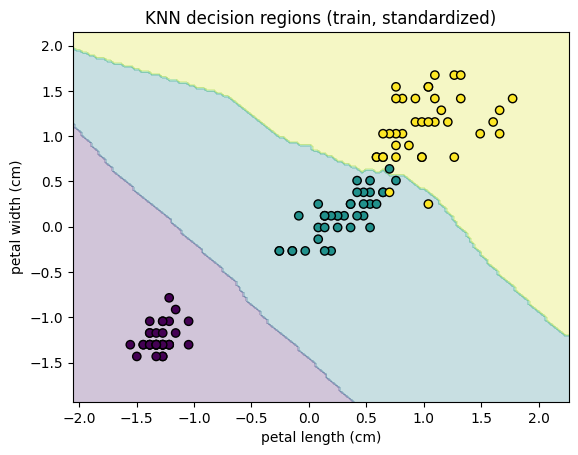

In [8]:
def plot_knn_decision_regions(model, X_std, y, title, xlabel="x1", ylabel="x2", h=0.03):
    x_min, x_max = X_std[:, 0].min() - 0.5, X_std[:, 0].max() + 0.5
    y_min, y_max = X_std[:, 1].min() - 0.5, X_std[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X_std[:, 0], X_std[:, 1], c=y, edgecolor="k")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_knn_decision_regions(
    clf, X_train_std, y_train,
    title="KNN decision regions (train, standardized)",
    xlabel=feat_names_2d[0], ylabel=feat_names_2d[1]
)


### Choosing k (bias–variance intuition)

- Small **k** → more flexible boundary (lower bias, higher variance)
- Large **k** → smoother boundary (higher bias, lower variance)

We sweep k and compare train/test accuracy.


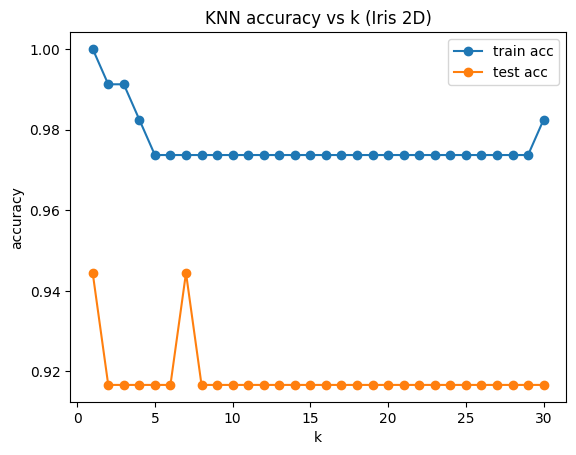

Best k by test accuracy: 1 test acc: 0.9444444444444444


In [9]:
ks = list(range(1, 31))
train_acc = []
test_acc = []

for k in ks:
    m = KNNClassifier(n_neighbors=k, metric="euclidean", weights="uniform").fit(X_train_std, y_train)
    train_acc.append(accuracy(y_train, m.predict(X_train_std)))
    test_acc.append(accuracy(y_test, m.predict(X_test_std)))

plt.figure()
plt.plot(ks, train_acc, marker="o", label="train acc")
plt.plot(ks, test_acc, marker="o", label="test acc")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("KNN accuracy vs k (Iris 2D)")
plt.legend()
plt.show()

best_k = ks[int(np.argmax(test_acc))]
print("Best k by test accuracy:", best_k, "test acc:", max(test_acc))


## 4. Part B — Regression on Diabetes

**Dataset:** Diabetes (442 samples, 10 standardized features already in sklearn, but we still treat it as raw input)  
Target `y` is a quantitative measure of disease progression.

We evaluate:
- RMSE
- R²

We also compare:
- `weights="uniform"` vs `weights="distance"`
- different k values


In [10]:
diab = load_diabetes()
Xr = diab.data
yr = diab.target
feat_r = diab.feature_names

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.25, shuffle=True, random_state=42
)

Xr_train_std, params_r = standardize(Xr_train, return_params=True)
Xr_test_std = (Xr_test - params_r["mean"]) / params_r["scale"]

print("Xr shape:", Xr.shape, "yr shape:", yr.shape)
print("Train mean (approx):", Xr_train_std.mean(axis=0)[:5])
print("Train std  (approx):", Xr_train_std.std(axis=0)[:5])


Xr shape: (442, 10) yr shape: (442,)
Train mean (approx): [ 0.  0.  0. -0. -0.]
Train std  (approx): [1. 1. 1. 1. 1.]


In [11]:
reg = KNNRegressor(n_neighbors=10, metric="euclidean", weights="distance").fit(Xr_train_std, yr_train)
yr_pred = reg.predict(Xr_test_std)

print("KNN Regressor (k=10, euclidean, distance)")
print("  RMSE:", rmse(yr_test, yr_pred))
print("  R^2 :", r2_score_np(yr_test, yr_pred))


KNN Regressor (k=10, euclidean, distance)
  RMSE: 59.197301854049684
  R^2 : 0.3657154407982659


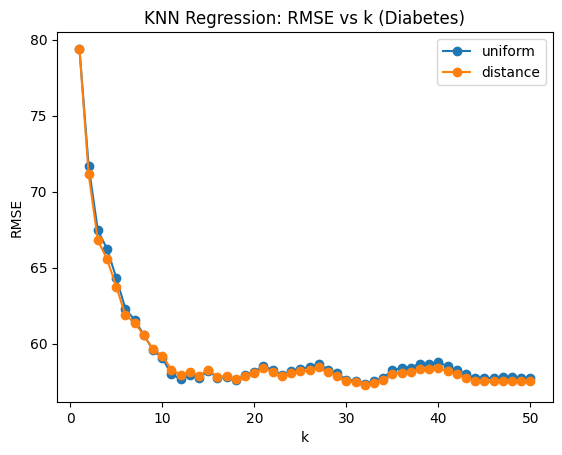

Best k (uniform): 32 RMSE: 57.347942626021904
Best k (distance): 32 RMSE: 57.275517380575344


In [12]:
ks = list(range(1, 51))
rmse_uniform = []
rmse_distance = []

for k in ks:
    m1 = KNNRegressor(n_neighbors=k, metric="euclidean", weights="uniform").fit(Xr_train_std, yr_train)
    p1 = m1.predict(Xr_test_std)
    rmse_uniform.append(rmse(yr_test, p1))

    m2 = KNNRegressor(n_neighbors=k, metric="euclidean", weights="distance").fit(Xr_train_std, yr_train)
    p2 = m2.predict(Xr_test_std)
    rmse_distance.append(rmse(yr_test, p2))

plt.figure()
plt.plot(ks, rmse_uniform, marker="o", label="uniform")
plt.plot(ks, rmse_distance, marker="o", label="distance")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.title("KNN Regression: RMSE vs k (Diabetes)")
plt.legend()
plt.show()

best_k_u = ks[int(np.argmin(rmse_uniform))]
best_k_d = ks[int(np.argmin(rmse_distance))]
print("Best k (uniform):", best_k_u, "RMSE:", min(rmse_uniform))
print("Best k (distance):", best_k_d, "RMSE:", min(rmse_distance))


## Conclusion

In this notebook, we implemented **k-Nearest Neighbors (KNN)** for both **classification** and **regression** using our NumPy-only `KNNClassifier` / `KNNRegressor`, and evaluated the models on **scikit-learn reference datasets**.

### KNN Classification (Iris, 2D)

- **Dataset:** Iris (3 classes). We used **two features**: *petal length* and *petal width*.
- **Performance (k=5, Euclidean, uniform):**
  - Train accuracy: **0.974**
  - Test accuracy: **0.917**
- **Best test accuracy in our sweep:** **k = 1**, test accuracy **0.944**.
  - This is a classic sign that with only 2 informative features, a very local decision rule can work well on this split.

**Confusion matrix insight (test):**
- *Setosa* was classified perfectly (no confusion).
- Most errors came from mixing **versicolor vs virginica**, which is expected because these two classes overlap more in this 2D feature space.

**Decision region plot:**
- The boundary is noticeably **piecewise and jagged**, which is typical for KNN.
- Smaller \(k\) generally produces **more flexible (higher-variance)** boundaries; larger \(k\) smooths them out but can underfit.

### KNN Regression (Diabetes)

- **Dataset:** Diabetes regression dataset (10 standardized features in the dataset; we also standardized with train stats for consistency).
- **Example model (k=10, Euclidean, distance):**
  - RMSE: **59.20**
  - \(R^2\): **0.366**
- **Best RMSE in our sweep:**
  - Best \(k\) (uniform): **32**, RMSE **57.35**
  - Best \(k\) (distance): **32**, RMSE **57.28**

**RMSE vs k plot interpretation:**
- RMSE drops quickly from very small \(k\) (high variance) and then **flattens around moderate \(k\)**, indicating a bias–variance tradeoff.
- In this run, **distance weighting** and **uniform weighting** perform very similarly at the best \(k\), suggesting neighbor averaging dominates once \(k\) is moderate.

In conclusion:
- KNN is simple and effective, but **highly sensitive to**:
  - feature scaling (standardization is crucial),
  - the choice of \(k\),
  - the distance metric,
  - and dimensionality (“curse of dimensionality”).

